In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import math
import random
import numpy as np
import cv2
sys.path.append('../')
from mrcnn.visualize  import display_images
from mrcnn.dataset    import Dataset
from mrcnn.shapes     import ShapesConfig
from mrcnn.datagen    import load_image_gt
from mrcnn.new_shapes import NewShapesConfig, NewShapesDataset
import  mrcnn.visualize as visualize
import  mrcnn.utils     as utils
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)

 

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


###  Routines that accept shape type and dimensions as inputs

In [ ]:
    
'''
-------------------------------------------------------------------------------
'''
def semi_random_image(self, height, width):
    '''
    Creates random specifications of an image with multiple shapes.
    Returns the background color of the image and a list of shape
    specifications that can be used to draw the image.
    '''
    # Pick random background color
    bg_color = np.array([random.randint(0, 255) for _ in range(3)])
    # Generate a few random shapes and record their
    # bounding boxes
    shapes = []
    boxes = []
    N = random.randint(1, 4)

    for _ in range(N):
        shape, color, dims = self.random_shape(height, width)
        shapes.append((shape, color, dims))
        x, y, sx, sy = dims
        boxes.append([y - sy, x - sx, y + sy, x + sx])

    # Suppress occulsions more than 0.3 IoU    
    # Apply non-max suppression with 0.3 threshold to avoid shapes covering each other
    keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)

    shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]

    # print('Original number of shapes {}  # after NMS {}'.format(N, len(shapes)))
    return bg_color, shapes

def semi_random_shape(height, width, shape = None, x = 0, y = 0, sx = 0, sy = 0):
    """Generates specifications of a random shape that lies within
    the given height and width boundaries.
    Returns a tuple of three valus:
    * The shape name (square, circle, ...)
    * Shape color: a tuple of 3 values, RGB.
    * Shape dimensions: A tuple of values that define the shape size
                        and location. Differs per shape type.
    """
    # Shape
    if shape is None:
        shape = random.choice(["square", "circle", "triangle", "rectangle"])
    # Color
    color = tuple([random.randint(0, 255) for _ in range(3)])
    # Center x, y
    buffer = 20
    if y == 0:
        y = random.randint(buffer, height - buffer - 1)
    if x == 0: 
        x = random.randint(buffer, width - buffer - 1)
    # Size
    if sx == 0 :
        sx = random.randint(buffer, width // 4)
    if shape == "rectangle" and sy == 0 :
        sy = random.randint(buffer, height // 4)
    else:
        sy = sx
#     print(' Shape : {}     Cntr (x,y) : ({} , {})    Size_x: {} Size_y: {}'.format(shape,x,y,sx, sy))    
    return shape, color, (x, y, sx, sy)

def semi_draw_shape(image, shape, dims, color):
    """Draws a shape from the given specs."""
    # Get the center x, y and the size s
    x, y, sx, sy = dims
    print(' Shape : {}     Cntr (x,y) : ({} , {})    Size_x: {} Size_y: {}'.format(shape,x,y,sx, sy))    
    if shape == 'square':
        image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)
    elif shape == 'rectangle':
        image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)        

    elif shape == "circle":
        image = cv2.circle(image, (x, y), sx, color, -1)

    elif shape == "triangle":
        sin60 = math.sin(math.radians(60))
        points = np.array([[(x, y - sx),
                            (x - (sx / sin60), y + sx),
                            (x + (sx / sin60), y + sx),
                            ]], dtype=np.int32)
#         print(' points.shape is : ',points.shape)
#         print(points)
        image = cv2.fillPoly(image, points, color)
    return image            

###  Non Max Suppression 

In [ ]:
from mrcnn.utils import compute_iou
def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum supression and returns indicies of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)
    # print(' non_max_suppression ')
    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    print('====> Initial Ixs: ', ixs)
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        cy = y1[i] + (y2[i]-y1[i])//2
        cx = x1[i] + (x2[i]-x1[i])//2
        print('     ix : ', ixs, 'ctr (x,y)', cx,' ',cy,' box:', boxes[i], ' compare ',i, ' with ', ixs[1:])
        pick.append(i)
        
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        print('     ious:', iou)
        # Identify boxes with IoU over the threshold. This
        # returns indicies into ixs[1:], so add 1 to get
        # indicies into ixs.
        tst =  np.where(iou>threshold)
        remove_ixs = np.where(iou > threshold)[0] + 1
        print('     np.where( iou > threshold) : ' ,tst, 'tst[0] (index into ixs[1:]: ', tst[0], 
         ' remove_ixs (index into ixs) : ',remove_ixs)
        
        # Remove indicies of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
        print(' ending ixs (after deleting ixs[0]): ', ixs, ' picked so far: ',pick)
    print('====> Final Picks: ', pick)
    return np.array(pick, dtype=np.int32)



###  NewShape Class Definition

In [ ]:
class NewShapesConfig(ShapesConfig):
    '''
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    '''
    # Give the configuration a recognizable name
#     NAME = "shapes"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 shapes


class NewShapesDataset(Dataset):
    '''
    Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    '''

    def load_shapes(self, count, height, width):
        '''
        Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        '''
        
        # Add classes
        self.add_class("shapes", 1, "circle")  # used to be class 2
        self.add_class("shapes", 2, "square")  # used to be class 1
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "rectangle")
        self.add_class("shapes", 5, "person")
        self.add_class("shapes", 6, "car")
        self.add_class("shapes", 7, "sun")
        self.add_class("shapes", 8, "building")
        self.add_class("shapes", 9, "tree")
        self.add_class("shapes",10, "cloud")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        '''
        Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but in this case it
        generates the image on the fly from the specs in image_info.
        '''
        
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        print(" Load Image ")
        pp.pprint(info['shapes'])

        #--------------------------------------------------------------------------------
        # rearrange the shapes by ascending Y, so that items closer to bottom of 
        # image overlay items further up
        #--------------------------------------------------------------------------------
        sort_lst = [itm[2][1] for itm in info['shapes']]
        sorted_shape_ind = np.argsort(np.array(sort_lst))
        
        for shape_ind in sorted_shape_ind:
#             print(' shape ind :', shape_ind, 'shape', shape, ' color:', color,' dims ',dims)
            shape, color, dims =  info['shapes'][shape_ind]
            image = self.draw_shape(image, shape, dims, color)
        return image

    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)    

            
    def load_mask(self, image_id):
        '''
        Generate instance masks for shapes of the given image ID.
        '''
        # print(' Loading shapes obj mask infofor image_id : ',image_id)
        info   = self.image_info[image_id]
        shapes = info['shapes']
        # print('\n Load Mask information (shape, (color rgb), (x_ctr, y_ctr, size) ): ')
        # pp.pprint(info['shapes'])
        count  = len(shapes)
        mask   = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        print(' Shapes obj mask shape is :',mask.shape)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i + 1] = self.draw_shape(mask[:, :, i:i + 1].copy(), shape, dims, 1)
        
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(
                occlusion, np.logical_not(mask[:, :, i]))
        
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)
    
    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, sx, sy = dims
        print(' Shape : {:20s}   Cntr (x,y): ({:3d} , {:3d})    Size_x: {:3d}   Size_y: {:3d} {}'.format(shape,x,y,sx, sy,color))        
        
        if shape == "square":
            image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)

        elif shape in ["rectangle", "building"]:
            image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)        
#             print('X :', x, 'y:', y , '     sx: ',sx , 'sy: ', sy, 'hs:', hs)
        
        elif shape == "car":
            body_y = sy //3
            wheel_x = sx //2
            wheel_r = sx //5
            top_x   = sx //4
            bot_x   = 3*sx //4
            image = cv2.rectangle(image, (x - sx, y - body_y), (x + sx, y + body_y), color, -1)    
            image = cv2.circle(image, (x - wheel_x , y + body_y), wheel_r, color, -1)     
            image = cv2.circle(image, (x + wheel_x , y + body_y), wheel_r, color, -1)     

            points = np.array([[(x - top_x , y - sy),   (x + top_x, y - sy),
                                (x + bot_x,  y - body_y),(x - bot_x, y - body_y), ]], dtype=np.int32)
            image = cv2.fillPoly(image, points, color)                     
            
        elif shape == "person":
#             hy = sy // 4   # head height
#             by = sy - hy   # body height
#             print('X :', x, 'y:', y , 'sx: ',sx , 'sy: ', sy, 'hs:', hs)                         
#             image = cv2.rectangle(image, (x - sx, y - by), (x + sx, y + by), color, -1)    
#             image = cv2.circle(image, (x , y -(by+hy) ), sx, color, -1)            

            hy = sy // 4   # head height
            by = sy - hy   # body height
#             print('X :', x, 'y:', y , 'sx: ',sx , 'sy: ', sy, 'hs:', hs)            
            # torso
            image = cv2.rectangle(image, (x - sx, y - by), (x + sx, y + by//4), color, -1)    
            # legs
            image = cv2.rectangle(image, (x - sx, y + by//4), (x - sx +sx//4, y + by), color, -1)    
            image = cv2.rectangle(image, (x + sx - sx//4, y + by//4), (x + sx, y + by), color, -1)    
            #head
            image = cv2.circle(image, (x , y -(by+hy) ), sx, color, -1)           
        elif shape in ["circle", "sun"]:
            image = cv2.circle(image, (x, y), sx, color, -1)

        elif shape in ["cloud", "ellipse"]:
            image = cv2.ellipse(image,(x,y),(sx, sy),0,0,360,color,-1)            

        elif shape == "triangle":
            sin60 = math.sin(math.radians(60))
            # orde of points: top, left, right
            points = np.array([[(x, y - sx),
                                (x - (sx / sin60), y + sx),
                                (x + (sx / sin60), y + sx),
                                ]], dtype=np.int32)
            image = cv2.fillPoly(image, points, color)
        
        elif shape == "tree":
            sin60 = math.sin(math.radians(60))
            ty = sy //3            # trunk length
            by = sy - ty           # body length
            tx = int((by /sin60)//5)   # trunk width
        #     print('sx: ',sx , 'sy: ', sy, 'tx/ty :', tx, ' bx: ',bx)
            sin60 = math.sin(math.radians(60))
            # orde of points: top, left, right
            points = np.array([[(x, y - by),
                                (x - (by / sin60), y + by),
                                (x + (by / sin60), y + by),
                                ]], dtype=np.int32)
            image = cv2.fillPoly(image, points, color)             
            image = cv2.rectangle(image,(x-tx,y+by), (x+tx, y+by+ty),color, -1)                      
            
        return image            

    def random_shape(self, shape, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
#         shape = random.choice(["square", "circle", "triangle", "rectangle", "person", "car"])
        
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        buffer = 20
        
        if shape == "person":
            min_range_x = buffer
            max_range_x = width - buffer - 1
#             min_range_y = (height //3) * 2
            min_range_y = (height //2)
            max_range_y = height - buffer - 1
            min_height = 10
            max_height = 22
            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)
#             sy = random.randint(min_height, max_height)
            sy = int(np.interp([y],[min_range_y, max_range_y], [min_height, max_height]))
            sx = sy //5    # body width 

        elif shape == "car":
#             min_range_x = buffer
#             max_range_x = width - buffer - 1
#             min_range_y = height //2
#             max_range_y = height - buffer - 1
#             min_width = 12
#             max_width = 15
#             x = random.randint(min_range_x, max_range_x)
#             y = random.randint(min_range_y, max_range_y)            
#             sx = random.randint(min_width , max_width)
#             sy = sx //3 

            min_range_x = buffer
            max_range_x = width - buffer - 1
            min_range_y = height //2
            max_range_y = height - buffer - 1

            min_width = 15
            max_width = 30 
            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)            
            ## scale width based on location on the image. Images closer to the bottom 
            ## will be larger
            sx = int(np.interp([y],[min_range_y, max_range_y], [min_width, max_width]))
            ## old method
            ## sx = random.randint(min_width , max_width)            
            sy = sx //2            
            
        elif shape == "building":            
            min_range_x = buffer
            max_range_x = width - buffer - 1           
            min_range_y = height //3
            max_range_y = 3 * height //4   ##* min_range_y
            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)            
            min_height = 10
            max_height = 30
            sy = int(np.interp([y],[min_range_y, max_range_y], [min_height, max_height]))
            #     sy = random.randint(min_height, max_height)
            #     sx = random.randint(5,15)
            sx = sy //2 + 5            
            
        elif shape == "sun":
            min_range_x = buffer //3
            max_range_x = width - (buffer//3) - 1           
            min_range_y = buffer //3
            max_range_y = height //5    ##* min_range_y
            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)                      
            min_height = 4
            max_height = 10
            sx = int(np.interp([y],[min_range_y, max_range_y], [min_height, max_height]))
#             sx = random.randint(min_height, max_height)            
            sy = sx

        elif shape == "tree":
            min_range_x = buffer  
            max_range_x = width - (buffer) - 1           
            min_range_y = height // 3
            max_range_y = width - (buffer) - 1    ##* min_range_y
            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)                      
            min_height = 8
            max_height = 24
            sy = int(np.interp([y],[min_range_y, max_range_y], [min_height, max_height]))    
            #     sy = random.randint(min_height, max_height)            
            sx = sy
                      
        elif shape == "cloud":               
            min_range_x = buffer//2 
            max_range_x = width - (buffer//2) - 1           
            min_range_y = buffer
            max_range_y = height //4
            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)                      
            min_width , max_width  = 15, 40 
        #     sx = random.randint(min_width, max_width)            
            sx = int(np.interp([y],[min_range_y, max_range_y], [min_width, max_width]))
        #     min_height ,max_height = 10, 20
        #     sy = random.randint(min_height, max_height)            
            sy = sx //  random.randint(3, 5)
                    
        else :
            min_range_x = buffer
            min_range_y = buffer
            max_range_x = width - buffer - 1
            max_range_y = height - buffer - 1
            min_size_x  = buffer
            max_size_x  = width // 4
            min_size_y  = buffer
            max_size_y  = height //4 

            x = random.randint(min_range_x, max_range_x)
            y = random.randint(min_range_y, max_range_y)
            sx = random.randint(min_size_x, max_size_x)

            if shape == "rectangle":
                sy = random.randint(min_size_y, max_size_y)    
            else:
                ## other shapes have same sx and sy             
                sy = sx

        return  color, (x, y, sx, sy)
    
    def random_image(self, height, width):
        '''
        Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        '''
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])

        # Generate a few random shapes and record their
        # bounding boxes
        tmp_shapes = []
        shapes = []
        boxes  = []
        N = random.randint(1, 7)
        shape_choices = ["person", "car", "sun", "building", "tree", "cloud"]
        
        for _ in range(N):
            shape = random.choice(shape_choices)            
            color, dims = self.random_shape(shape, height, width)
            tmp_shapes.append((shape, color, dims))
            if shape == "sun":
                shape_choices.remove("sun")
            x, y, sx, sy = dims
#             boxes.append([y - sy, x - sx, y + sy, x + sx])

        #--------------------------------------------------------------------------------
        # order shape objects based on closeness to bottom of image
        # this will result in items closer to the viewer have higher priority in NMS
        #--------------------------------------------------------------------------------
        print(" Random Image Routine ")
        pp.pprint(tmp_shapes)

        sort_lst = [itm[2][1] for itm in tmp_shapes]
        print(sort_lst)
        sorted_shape_ind = np.argsort(np.array(sort_lst))[::-1]
        print(sorted_shape_ind)
        
        for i in sorted_shape_ind:
            shapes.append(tmp_shapes[i])
            x, y, sx, sy = tmp_shapes[i][2]
            boxes.append([y - sy, x - sx, y + sy, x + sx])            
            
        print('=== Sahpes after sorting ===')
        pp.pprint(shapes)
        pp.pprint(boxes)
        # Suppress occulsions more than 0.3 IoU    
        # Apply non-max suppression with 0.3 threshold to avoid shapes covering each other
        # object scores (which dictate the priority) are assigned in the order they were created
        print('===== non-max-suppression =====')
        keep_ixs =  non_max_suppression(np.array(boxes), np.arange(N), 0.29)
        
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        
        print('===> Original number of shapes {}  # after NMS {}'.format(N, len(shapes)))
        return bg_color, shapes    
    
    

In [2]:
test  = NewShapesDataset()
test.load_shapes(10, 128, 128)
test.prepare()
test_config = NewShapesConfig()
test.image_ids

 Shapes Per Image:  7
 Add image --->  0
    ===> Image Id : ( 6 )   ---- Zero Mask Encountered 
    ------ Original Shapes ------
[       ('cloud', (145, 184, 235), (98, 20, 15, 3)),
        ('tree', (231, 5, 101), (27, 55, 11, 11)),
        ('tree', (248, 41, 144), (44, 82, 17, 17)),
        ('building', (233, 232, 186), (39, 84, 19, 29)),
        ('tree', (61, 220, 109), (84, 89, 19, 19)),
        ('person', (148, 203, 149), (93, 103, 4, 24)),
        ('tree', (148, 222, 35), (82, 104, 23, 23))]
    ------ shapes after removal of totally hidden shapes ------
[       ('cloud', (145, 184, 235), (98, 20, 15, 3)),
        ('tree', (231, 5, 101), (27, 55, 11, 11)),
        ('building', (233, 232, 186), (39, 84, 19, 29)),
        ('tree', (61, 220, 109), (84, 89, 19, 19)),
        ('person', (148, 203, 149), (93, 103, 4, 24)),
        ('tree', (148, 222, 35), (82, 104, 23, 23))]
    Number of shapes now is :  6
 Initialize config object - super
(56, 56)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

###  Display Images 

(1,) (1, 4) (128, 128, 1)
[[49 77 69 97]]
[5]


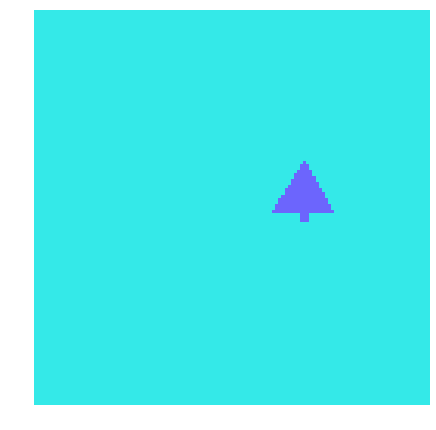

(2,) (2, 4) (128, 128, 2)
[[13 22 32 41]
 [60 51 96 58]]
[3 1]


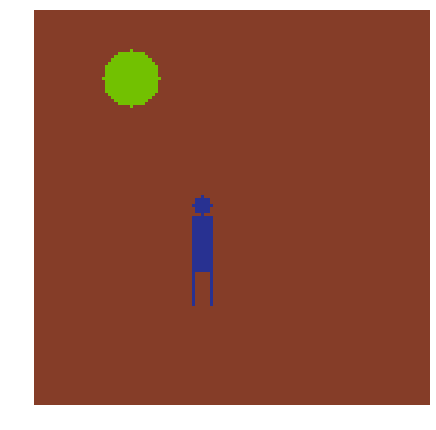

(4,) (4, 4) (128, 128, 4)
[[  5  44  16  55]
 [ 54  68  77  90]
 [ 63  42  89  62]
 [ 53   3 110  42]]
[3 5 5 4]


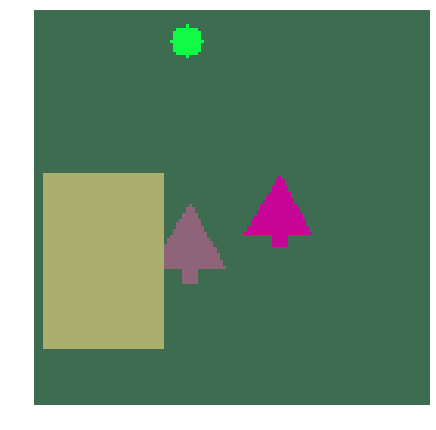

(2,) (2, 4) (128, 128, 2)
[[ 34  14  55  35]
 [ 35  85  60 108]]
[4 4]


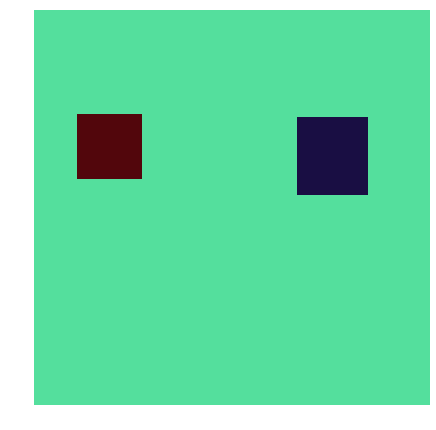

(2,) (2, 4) (128, 128, 2)
[[11  7 26 22]
 [57 64 70 95]]
[3 2]


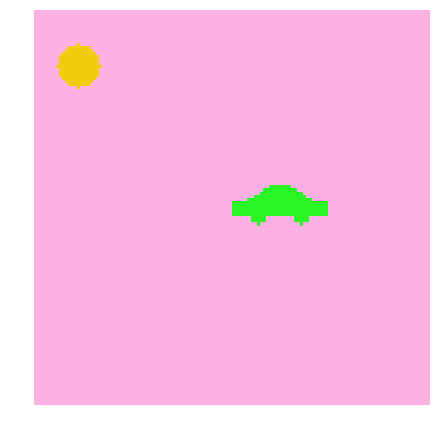

(4,) (4, 4) (128, 128, 4)
[[  5 100  16 111]
 [ 16  63  27  98]
 [ 35  82  60 105]
 [ 60  63  85  87]]
[3 6 4 5]


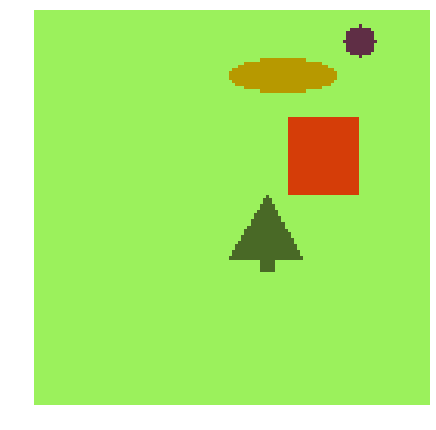

(5,) (5, 4) (128, 128, 5)
[[ 17  83  24 114]
 [ 47  17  64  32]
 [ 55  20 114  59]
 [ 75  89 122  98]
 [ 88  63 128 101]]
[6 5 4 1 5]


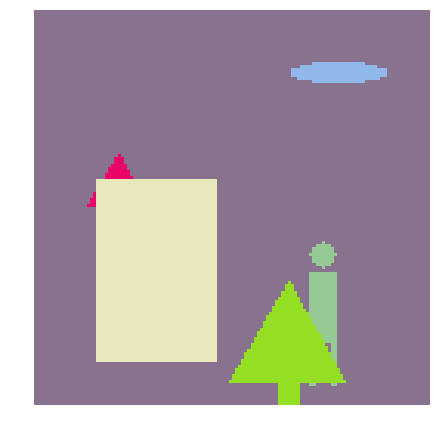

(6,) (6, 4) (128, 128, 6)
[[  7  78  16  91]
 [ 15  71  26 100]
 [ 16  94  31 128]
 [ 37  75  66 100]
 [ 50  74  82  81]
 [ 64  68 104  77]]
[3 6 6 4 1 1]


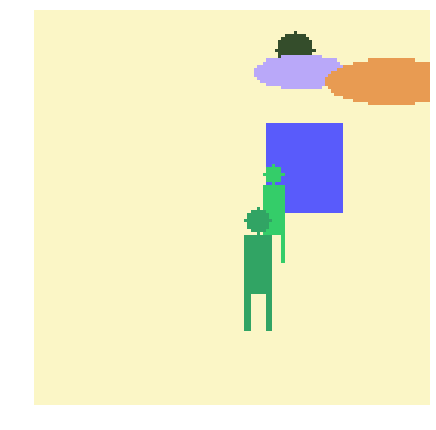

(6,) (6, 4) (128, 128, 6)
[[ 15 105  34 124]
 [ 22  12  39  83]
 [ 40  39  55  53]
 [ 40  53  73  80]
 [ 55  24  78  46]
 [ 77  51  96  98]]
[3 6 5 4 5 2]


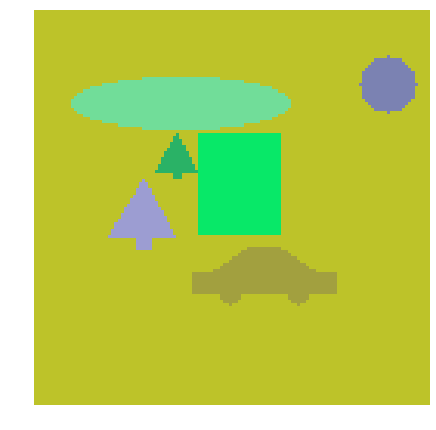

(7,) (7, 4) (128, 128, 7)
[[  5  47  16  58]
 [ 35  66  58  87]
 [ 65  84  81 117]
 [ 67  12  97  36]
 [ 53  36 108  73]
 [ 68  87 110  96]
 [ 70  77 114  86]]
[3 4 2 5 4 1 1]


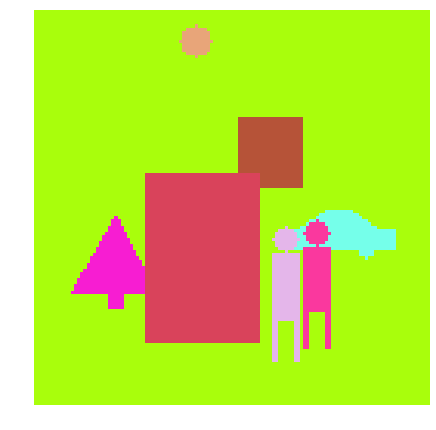

In [3]:
for image_id in range(len(test.image_ids)):
#     print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    load_image_gt(test, test_config, image_id, augment=False, use_mini_mask=False) 
        
#     print(test.image_info[image_id])
#     for shape, color, dims in test.image_info[image_id]['shapes']:        
#         x, y, sx, sy = dims
#         print(' Shape : {:20s}     Cntr (x,y): ({:3d} , {:3d})    Size_x: {:3d}   Size_y: {:3d}'.format(shape,x,y,sx, sy))            
    print(gt_class_ids.shape, gt_boxes.shape, gt_masks.shape)
    print(gt_boxes)
    print(gt_class_ids)
    visualize.display_images([image], cols = 1, width = 8)                     
#     visualize.display_instances(image, gt_boxes, gt_masks, gt_class_ids, test.class_names, figsize=(8, 8))
#     visualize.display_top_masks(image, gt_masks, gt_class_ids, test.class_names)
    

###  Construct a semi-random image 

In [ ]:
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
color = tuple([random.randint(0, 255) for _ in range(3)])

image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)
for i in range(5):
    shape , color, dims = semi_random_shape(img_h, img_w )
    image = semi_draw_shape(image , shape, dims ,color)

display_images([image], cols = 1, width = 6)

###  Display one image

In [ ]:
image_index = 3
image_id = test.image_ids[image_index]
image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(test, test_config, image_id, augment=False, use_mini_mask=False)
    
print(gt_class_ids.shape, gt_boxes.shape, gt_masks.shape)
print(gt_boxes)
print(gt_class_ids)
display_images([image], cols = 1, width = 6)
# draw_boxes(image, gt_boxes)    

### Experiemnt building shapes

In [ ]:
height , width = 128, 128
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
buffer = 10
image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)

for i in range(4):
    color = tuple([random.randint(0, 255) for _ in range(3)])
    min_range_x = buffer
    max_range_x = width - buffer - 1           
    min_range_y = height //3
    max_range_y = 3 * height //4   ##* min_range_y
    x = random.randint(min_range_x, max_range_x)
    y = random.randint(min_range_y, max_range_y)            


    min_height = 10
    max_height = 30
    sy = np.interp([y],[min_range_y, max_range_y], [min_height, max_height])    
    #     sy = random.randint(min_height, max_height)
#     sx = random.randint(5,15)
    sx = sy //2 + 5

    image = cv2.rectangle(image, (x - sx, y - sy), (x + sx, y + sy), color, -1)      
display_images([image], cols = 1, width = 8)

###  Automobile

In [ ]:
height , width = 128, 128
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
buffer = 10
image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)

for i in range(4):
    color = tuple([random.randint(0, 255) for _ in range(3)])
    min_range_x = buffer
    max_range_x = width - buffer - 1
    min_range_y = height //2
    max_range_y = height - buffer - 1
    x = random.randint(min_range_x, max_range_x)
    y = random.randint(min_range_y, max_range_y)          
    min_width = 12
    max_width = 26     
    ## scale width based on location on the image. Images closer to the bottom 
    ## will be larger
    sx = np.interp([y],[min_range_y, max_range_y], [min_width, max_width])
    ## old method
    ## sx = random.randint(min_width , max_width)
    sy = sx //2

    print('X :', x, 'y:', y , '     sx: ',sx , 'sy: ', sy)
    
    body_y  = sy //3
    wheel_x = sx //2
    wheel_r = sx //5
    top_x   = sx //4
    bot_x   = 3*sx //4
    image = cv2.rectangle(image, (x - sx, y - body_y), (x + sx, y + body_y), color, -1)    
    image = cv2.circle(image, (x - wheel_x , y + body_y), wheel_r, color, -1)     
    image = cv2.circle(image, (x + wheel_x , y + body_y), wheel_r, color, -1)     
    
    points = np.array([[(x - top_x , y - sy),   (x + top_x, y - sy),
                        (x + bot_x,  y - body_y),(x - bot_x, y - body_y), ]], dtype=np.int32)
    image = cv2.fillPoly(image, points, color)             
    
display_images([image], cols = 1, width = 8)

### Trees

In [ ]:
height , width = 128, 128
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
buffer = 20
sin60 = math.sin(math.radians(60))

image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)

for i in range(7):
    color = tuple([random.randint(0, 255) for _ in range(3)])
    min_range_x = buffer  
    max_range_x = width - (buffer) - 1           
    min_range_y = height // 3
    max_range_y = width - (buffer) - 1    ##* min_range_y
    x = random.randint(min_range_x, max_range_x)
    y = random.randint(min_range_y, max_range_y)                      
    min_height = 8
    max_height = 24
    sy = np.interp([y],[min_range_y, max_range_y], [min_height, max_height])    
#     sy = random.randint(min_height, max_height)            
    sx = sy
    
    ty = sy //3            # trunk length - 1/3 total length 
    by = sy - ty           # body length  ~ 2/3 total length
    tx = int((by /sin60)//5)   # trunk width
#    print('sx: ',sx , 'sy: ', sy, 'tx/ty :', tx, ' bx: ',bx)
    # orde of points: top, left, right
    points = np.array([[(x, y - by),
                        (x - (by / sin60), y + by),
                        (x + (by / sin60), y + by),
                        ]], dtype=np.int32)

    image = cv2.fillPoly(image, points, color)             
    image = cv2.rectangle(image,(x-tx,y+by), (x+tx, y+by+ty),color, -1)

# for i in range(5):
#     shape , color, dims = semi_random_shape(img_h, img_w )
#     image = semi_draw_shape(image , shape, dims ,color)

display_images([image], cols = 1, width = 6)

###  Airplane

In [ ]:
height , width = 128, 128
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
buffer = 20
image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)

for i in range(7):
    color = tuple([random.randint(0, 255) for _ in range(3)])
    min_range_x = buffer //3
    max_range_x = width - (buffer//3) - 1           
    min_range_y = height //3
    max_range_y = 2* height // 3    ##* min_range_y
    x = random.randint(min_range_x, max_range_x)
    y = random.randint(min_range_y, max_range_y)                      
    min_height = 8
    max_height = 24
    sy = random.randint(min_height, max_height)            
    sx = sy

### DRAW ------------------------------------------------    
    
    tx = sx //3            # trunk length - 1/3 of total length 
    bx = sx - tx           # body length
    by = (bx/sin60)        # body width
    ty = int(by//5)   # trunk width

#     print('sx: ',sx , 'sy: ', sy, 'tx/ty :', tx, ' bx: ',bx)
    sin60 = math.sin(math.radians(60))
    # orde of points: top, left, right
#     points = np.array([[(x, y - by),
#                         (x - (by / sin60), y + by),
#                         (x + (by / sin60), y + by),
#                         ]], dtype=np.int32)
    points = np.array([[(x - bx , y),
                        (x + bx , y - by),
                        (x + bx , y + by),
                        ]], dtype=np.int32)

    image = cv2.fillPoly(image, points, color)             
    image = cv2.rectangle(image,(x+bx,y-ty), (x+bx+tx, y+ty),color, -1)

# for i in range(5):
#     shape , color, dims = semi_random_shape(img_h, img_w )
#     image = semi_draw_shape(image , shape, dims ,color)

display_images([image], cols = 1, width = 6)

###  person

In [ ]:
height , width = 128, 128
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
buffer = 10
image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)

for i in range(7):
    color = tuple([random.randint(0, 255) for _ in range(3)])
    min_range_x = buffer
    max_range_x = width - buffer - 1
    min_range_y = (height //2)
    max_range_y = height - buffer - 1
    min_height = 10
    max_height = 22
    x = random.randint(min_range_x, max_range_x)
    y = random.randint(min_range_y, max_range_y)
#     sy = random.randint(min_height, max_height)
    sy = np.interp([y],[min_range_y, max_range_y], [min_height, max_height]) 
    sx = sy // 5   # body width 
    
### DRAW ------------------------------------------------    
    
    hy = sy // 4   # head height
    by = sy - hy   # body height
    print('X :', x, 'y:', y , 'sx: ',sx , 'sy: ', sy)
    
    # torso
    image = cv2.rectangle(image, (x - sx, y - by), (x + sx, y + by//4), color, -1)    
    # legs
    image = cv2.rectangle(image, (x - sx, y + by//4), (x - sx +sx//4, y + by), color, -1)    
    image = cv2.rectangle(image, (x + sx - sx//4, y + by//4), (x + sx, y + by), color, -1)    
    #head
    image = cv2.circle(image, (x , y -(by+hy) ), sx, color, -1)     

display_images([image], cols = 1, width = 6)

###  Ellipse

In [ ]:
height , width = 128, 128
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
buffer = 10
image = np.ones([img_h, img_w, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)

for i in range(3):
    color = tuple([random.randint(0, 255) for _ in range(3)])
    min_range_x = buffer//2 
    max_range_x = width - (buffer//2) - 1           
    min_range_y = buffer
    max_range_y = height //4
    x = random.randint(min_range_x, max_range_x)
    y = random.randint(min_range_y, max_range_y)                      
    min_width , max_width  = 15, 40 
#     sx = random.randint(min_width, max_width)            
    sx = np.interp([y],[min_range_y, max_range_y], [min_width, max_width]) 
#     min_height ,max_height = 10, 20
#     sy = random.randint(min_height, max_height)            
    sy = sx //  random.randint(3, 5)
    
### DRAW ------------------------------------------------      
    
    print('sx: ',sx , 'sy: ', sy, 'tx/ty :', tx)
    image = cv2.ellipse(image,(x,y),(sx, sy),0,0,360,color,-1)

display_images([image], cols = 1, width = 6)